# Predicting House Prices Using Regression

In this project we will be Predictingthe following: 


INPUT:
    the house was sold in 2015                                                                                 
    it is 9 years old                                                
    it has 4 stores nearby         
    located 5 kms away from the train station
    located exaclty at
    (45.55699, 65.982233001)
    
    
    
    
OUTPUT: 
    the price of the house was probably $ 128k

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

Importing Data

In [2]:
column_names=['serial','date','age','distance','stores','latitude','longitude','price']
df= pd.read_csv(r'C:\Users\KIIT\Desktop\data.csv', names= column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


Check missing data
It is a good practice to check missing data as in real world problems it is quite common and _must_ be taken care of before preprocessing or model training.

In [3]:
df.isna().sum()  #isna sends true for each missing value in the coloumn and here sum of all missing values is displayed

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Data Normalization

we can make it easier for optimization algorithms to find minimas by normalizing the data before training the models.

Normalization refers to rescaling real valued numeric attributes into the range 0 and 1.

it makes the model more consistent if all the features have the same scale.

In [4]:
df.iloc[:, 1:]     # df.iloc[rows, colms]  rows = : all rows selected, colms = 1: all cols except 1st are selected
df_norm = (df - df.mean())/ df.std()
df_norm.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,-1.731531,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-1.730839,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,-1.730146,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.729453,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,-1.728760,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


_CONVERT LABEL VALUE_
since price has been normalized, we will get the predictions from the model in the similar scale. We have to write a function to convert the normalized value of price back to the original distribution. (0.350088 back to 14264, -1.836486 back to 12032)

In [5]:
y_mean= df['price'].mean()
y_std = df['price'].std()

def convert_label_value(prediction):
    return int(prediction * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Create Training and test sets

FEATURE SELECTION

make sure to remove the coloumn _price_ from the features as it is a label and should not be used as a feature

In [6]:
x = df_norm.iloc[:, :6]
x.head()

,serial,date,age,distance,stores,latitude
0,-1.731531,0.015978,0.181384,1.257002,0.345224,-0.307212
1,-1.730839,-0.350485,-1.319118,-0.930610,-0.609312,0.325301
2,-1.730146,1.298598,-0.083410,-0.618094,0.663402,1.590328
3,-1.729453,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238
4,-1.728760,0.932135,0.534444,0.006938,0.981581,-1.255981


LABEL SELECTION

In [7]:
y = df_norm.iloc[:, -1]
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

FEATURE AND LABEL VALUES

we will need to extract just the numeric values for the features and labels as the TensorFlow model expects just numeric values as input

In [8]:
x_arr = x.values
y_arr = y.values
print('features array shape :', x_arr.shape)
print('labels array shape :', y_arr.shape)

features array shape : (5000, 6)
labels array shape : (5000,)


TRAIN AND TEST SPLIT

we will put a part of the data set aside as test set. The model will not use this test set durinf training and it will be used only to check performance of the model

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size= 0.05, random_state=0)

print('Shape of the training set : ', x_train.shape, y_train.shape)
print('Shape of the testing set : ', x_test.shape, y_test.shape)

Shape of the training set :  (4750, 6) (4750,)
Shape of the testing set :  (250, 6) (250,)


# Creating the Model

lets write a function that creates an untrained model of certain architechture

In [10]:
def get_model():
    model = Sequential([
        Dense(10, input_shape=(6,), activation ='relu'),
        Dense(20, activation ='relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])                          # three layers[Dense stmts], Dense(1) output layer. input shape=6 as 6 features
    model.compile(
        loss ='mse',
        optimizer ='adam'
    )                          # loss=mean scape error.This is the loss function that optimizer algorithm tries to minimize.
    return model
get_model().summary()          # Dense layer = fully connected layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## Model Training

we can use _EarlyStopping_ callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs

In [11]:
es_cb = EarlyStopping(monitor = 'val_loss', patience = 5)
model = get_model()
preds_on_untrained = model.predict(x_test)

history = model.fit(x_train, y_train,
                   validation_data = (x_test, y_test),
                   epochs = 100,
                   callbacks =[es_cb])

Epoch 1/100
149/149 [==============================] - 1s 5ms/step - loss: 0.3512 - val_loss: 0.2099
Epoch 2/100
149/149 [==============================] - 1s 3ms/step - loss: 0.1990 - val_loss: 0.1768
Epoch 3/100
149/149 [==============================] - 1s 3ms/step - loss: 0.1746 - val_loss: 0.1585
Epoch 4/100
149/149 [==============================] - 1s 3ms/step - loss: 0.1672 - val_loss: 0.1574
Epoch 5/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1610 - val_loss: 0.1513
Epoch 6/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1580 - val_loss: 0.1568
Epoch 7/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1561 - val_loss: 0.1538
Epoch 8/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1552 - val_loss: 0.1504
Epoch 9/100
149/149 [==============================] - ETA: 0s - loss: 0.153 - 1s 5ms/step - loss: 0.1541 - val_loss: 0.1524
Epoch 10/100
149/149 [==============================] - 0s 3ms/step

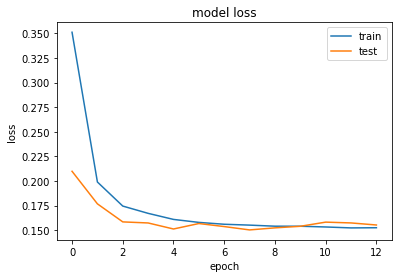

In [12]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper right')

plt.show()

# Predictions

PLOT RAW PREDICTIONS


In [13]:
def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 'ro')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--')
    plt.show()
    return

def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

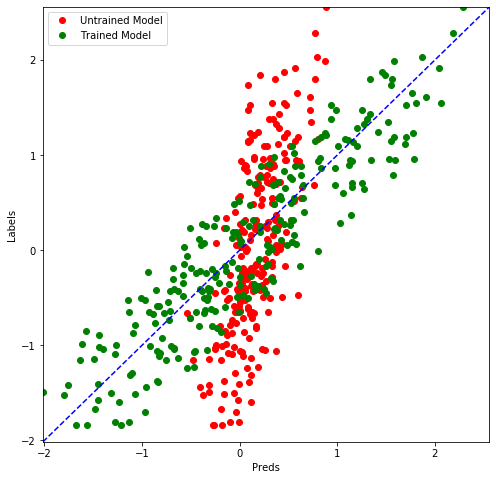

In [14]:
preds_on_trained = model.predict(x_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test) 

# In an ideal situation our model should make predictions same as labels, which is the dotted blue line
# But we can see that predictions by the untrained model is very inacurate compared to the trained model.

PLOTTING PRICE PREDICTIONS

the plot for price predictions and raw predictions will look just the same with one difference : x and y scale has changed

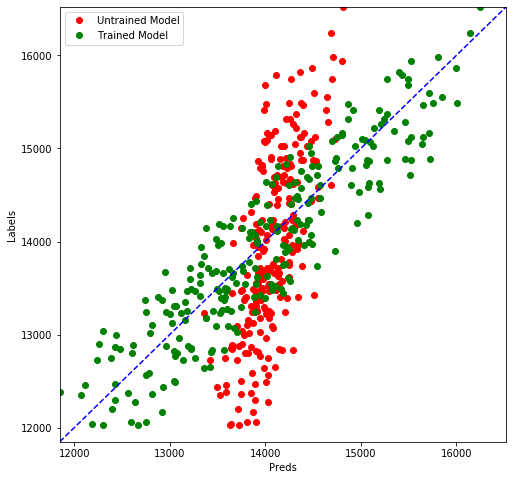

In [15]:
price_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_trained = [convert_label_value(y) for y in preds_on_trained]
price_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_untrained, price_trained, price_test)